# X Revenue Forecast

<br>

### FORECASTING CYCLICAL REVENUE USING FACEBOOK PROPHET
*ADDITIVE LINEAR REGRESSION*

**Author:** Cole Fairbanks, Data Scientist

**Contact:** ccole.fairbanks@gmail.com | [LinkedIn](linkedin.com/in/colefairbanks)

**About Prophet:**  Prophet is an open source library published by Facebook that is based on decomposable (trend+seasonality+holidays) models. It provides Analysts the ability to create accurate time series forecasts and add regressors as well as the flexibility to adjust parameters like seasonality and holidays.  Prophet is especially suited for revenue and other business-oriented data that has clear seasonality and spans a few years on a monthly or weekly basis.

Regarding how Prophet was built, this alogrithm sees forecasting primarily as a curve fitting exercise using probabilistic techniques used in various well-known additive models like ARIMA. If you are interested in learning more about the mathematical components of Prophet, I suggest reading the original Prophet paper, [Forecasting at Scale](https://peerj.com/preprints/3190/), by Sean J Taylor, Benjamin Letham.

**Business Challenge:**  Company X's Finance Dept., while able to confidently predict X hardware (HW) sales two years out, has struggled to produce accurate revenue forecasts for the maintenance (MA) side of their business, which is similar to Apple Care but for legacy servers. This is a problem for Finance, as these forecasts are the basis for  long-term budgets as well as short-term business decisions.  As a Data Scientist familiar with financial data, we have been asked to forecast MA revenue for one of Company X's flagship brands, X.  The CFO is particularly interested in having reliable automated forecasts that extend beyond 6 months, with an ideal time horizon of 24 months and a consistent accuracy of 92% or above.  Fortunately, upon initial inspection, X’s historical 10-year monthly MA revenue seems to follow a predictable pattern that may allow us to deliver on the CFO's expectations.  The challenge, however, will be to factor in the relationship between HW, MA, as well as X’s unique 2-year product life cycle.

**Skills Needed to Operate:** Intermediate Python, numpy, pandas, matplotlib, basic statistics, and working knowledge of linear regression.

**Language(s):** Python

### Installing Prophet Package

In [119]:
#!pip install fbprophet

### Loading Libraries

In [120]:
import math
import warnings
import calendar
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats
from fbprophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation,performance_metrics

### Input

This model has been optimized for 2 year forecasts, or 26 months due to the nature of Z's 2 year product life cycle and the Z HW regressor column.  However, you may choose how many months out you would like to forecast by typing in the number of desired months below:

In [121]:
months_out = 26

### Reading in CSV

In [122]:
actuals_df = pd.read_csv('/Users/colefairbanks/github/fbprophet-xforecast/historical_x_revenue.csv')

### Formating X Revenue Data Into

The format of the dataframe is very important to Prophet.  The date column, for example needs to be labeled as "ds" and contain datetime data.  In addition, the forecast model output or y must be labeled as "y".  In this case, our y values will reflect hardware maintenence revenue (HWMA).  Because Finance has also provided HW (not maintenence) revenue, we will use it within this model as a regressor, given thier inverse relationship.  There are no requirements for regressor labels and so, we will label it "hw".

In [123]:
#converting Date column to datetime type
actuals_df['Date'] = pd.to_datetime(actuals_df['Date'])

#grabbing relevant columns from dataframe
actuals_df = actuals_df[['Date','Revenue_XMA_M','Revenue_XHW_M']].reset_index(drop=True)

#renaming columns to comply with fbprophet format
actuals_df.columns = ['ds','y','hw']

#view last 5 rows of actuals_df
actuals_df.tail()

,ds,y,hw
145,2022-02-01,43.490665,47.495255
146,2022-03-01,49.092953,279.512029
147,2022-04-01,64.041966,25.863437
148,2022-05-01,47.060985,74.087494
149,2022-06-01,50.527594,990.120315


#### Formatting Regressor - Quick Note

After speaking with product X's business leaders and conducting an initial analysis of the data, it became clear that HW sales impact MA sales roughly 26 months later, which is consistent with X's 2-year product life cycle.  According to the business, once a new product is released, old machines that have maintenence attached are replaced with newer machines that come with a 2-year warranty.  This negatively affects MA revenue.  However, after 2 years, the warranties expire and MA revenue picks up again, which we will in upcoming visualizations.

To avoid overcomplicating the notebook, I formatted the csv file so that all we need to do is shift the hardware revenue column 26 periods (months) in the future so that it correlates with the MA revenue,

In [124]:
#creating a new df that only has date and hw
hw_df = actuals_df[['ds','hw']]

#setting the index to the date
hw_df = hw_df.set_index('ds')

#shifting index 26 periods into the future
hw_df = hw_df.shift(periods=26,freq='M')

In [125]:
#grabbing only date and ma revenue from actuals df
actuals_df = actuals_df[['ds','y']]

#setting the index to the date
actuals_df = actuals_df.set_index('ds')

#converting 1st day of month to last day of month to match hw_df
actuals_df = actuals_df.shift(periods=1,freq='M')

#concatenating both dataframes and reassigning as actuals_df
actuals_df = pd.concat([actuals_df, hw_df], axis = 1)

#resetting index so format complies with fbprophet
actuals_df = actuals_df.reset_index(drop=False)

In [126]:
#converting all 0s to None
actuals_df.loc[(actuals_df['y'] == 0), 'y'] = None

#dropping nans within hw column, which represents the prior 26 months that we shifted past
actuals_df = actuals_df.dropna(subset=['hw']).reset_index(drop=True)

Just to prove the two columns are now correlated, we can do a simple test.

In [127]:
actuals_df['y'].corr(actuals_df['hw'])

0.6532653524218366

.63 represents a moderately positive relationship, which makes sense because we are essentially aligning these two product life cycles (HW and MA) so that they run parallel to one another.

#### Plotting Revenue Actuals

This is a visual representation of X MA revenue, represented by the y axis. The date represents by the x axis.   Visual aids are important to any Analyst planning to build or maintain simialar models, given the complexities of formatting data and operating the algorithms themselves.  Graphs like this one give Analysts a sense of verification they are operating the model correctly. For that reason, we will continue to visualize our steps and end product with matplotlib. 

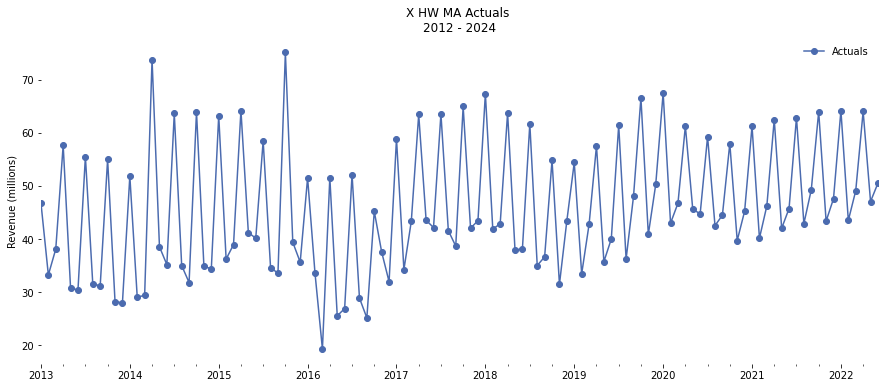

In [128]:
actuals_df2 = actuals_df.copy()
actuals_df2 = actuals_df2.set_index('ds')

year_begin = actuals_df2.index.year[0].astype(str)
year_end = actuals_df2.index.year[-1].astype(str)
    
title='X HW MA Actuals \n' + year_begin + ' - ' + year_end
ylabel='Revenue (millions)'
xlabel=''
    
ax = actuals_df2['y'].plot(legend=True,figsize=(15,6),title=title,label='Actuals',marker='o',color='#4B6BAF')
    
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False);

#### Calculating Mean, Median, Mode, Min, Max, Standard Deviation, and Skew

In [129]:
mean = actuals_df2['y'].mean()
median = actuals_df2['y'].median()
mode = round(actuals_df2['y']).mode()[0].astype(int)
min = actuals_df2['y'].min()
max = actuals_df2['y'].max()
std = actuals_df2['y'].std()
skew = actuals_df2['y'].skew()

ct_data = [{'Mean': round(mean), 'Median': round(median), 'Min': round(min), 'Max': round(max), 'Mode': round(mode), 'Std': round(std), 'Skew': skew}] 
ct_df = pd.DataFrame(ct_data)
ct_df = ct_df.style.set_properties(**{'text-align': 'center'}).hide_index()

#### Plotting Central Tendency

/Users/colefairbanks/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/colefairbanks/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


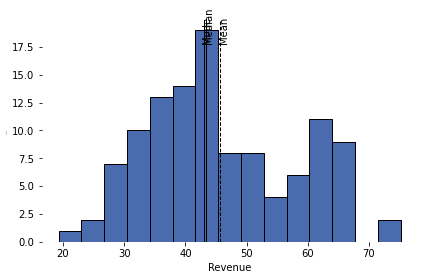

Mean,Median,Min,Max,Mode,Std,Skew
46,43,19,75,43,12,0.359503


In [130]:
ax = plt.subplot(frameon=False)
ax.hist(actuals_df2['y'], bins = 15, color = '#4B6BAF', edgecolor = 'black')
ax.set_xlabel('Revenue', size = 10)
ax.set_ylabel('Frequency', size= 1) 
plt.axvline(mean, color='k', linestyle='dashed', linewidth=1)
plt.axvline(median, color='k', linestyle='solid', linewidth=1)
plt.axvline(mode, color='k', linestyle='solid', linewidth=1)
plt.text(median-.25,18,'Median',rotation=90)
plt.text(mean-.25,18,'Mean',rotation=90)
plt.text(mode-.25,18,'Mode',rotation=90)
plt.tight_layout()
plt.show();
ct_df

Understanding central tendency is important to any times series analysis, as it gives the user a first look at the data's shape and behavior.

### Normalize Data Using Measures of Central Tendency

Many datasets tend to have missing data and/or statistical outliers that can increase error and skew model results.  By calculating measures of central tendency like mean, median, and mode, we can learn more about the data we are working with and potentially replace those outliers and/or missing values with a value like mean, which can ultimately reduce our error.  Unlike many other models, Prophet also accepts replacing outliers with "None".

In [131]:
actuals_df['moving_average'] = actuals_df.rolling(window=6, min_periods=1, center=True, on='ds')['y'].mean()
actuals_df['std_dev'] = actuals_df.rolling(window=26, min_periods=1, center=True, on='ds')['y'].std()
actuals_df['lower'] = actuals_df['moving_average'] - 1.645 * actuals_df['std_dev']
actuals_df['upper'] = actuals_df['moving_average'] + 1.645 * actuals_df['std_dev']

<ipython-input-160-c7ba2af6530d>:24: RuntimeWarning: invalid value encountered in less
  ax1.fill_between(x, lower, upper, where=(lower < upper), color='#808080', alpha=0.05)


,ds,y,hw,moving_average,std_dev,lower,upper


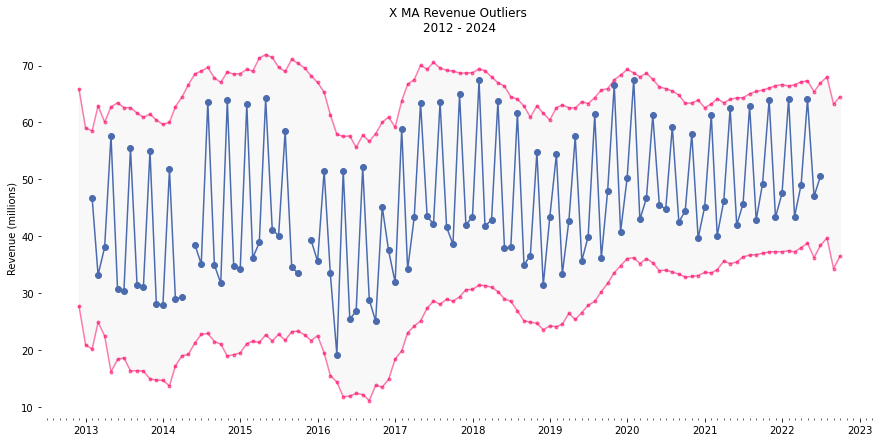

In [160]:
actuals_df2 = actuals_df.copy()

x = np.array(actuals_df2['ds'])
actuals = actuals_df2['y']
lower = np.array(actuals_df2['lower'])
upper = np.array(actuals_df2['upper'])

fig, ax1 = plt.subplots(figsize=(15,7))

actuals_df2 = actuals_df2.set_index('ds')
year_begin = actuals_df2.index.year[0].astype(str)
year_end = actuals_df2.index.year[-1].astype(str)
    
title='X MA Revenue Outliers \n' + year_begin + ' - ' + year_end
ylabel='Revenue (millions)'
xlabel=''

ax1.set_title(title)
ax1.set(ylabel=ylabel)

ax1.plot(x, actuals, color='#4B6BAF',label='_nolegend_',marker='o')
ax1.plot(x, lower, color='#FF0066' ,alpha=0.5,label='_nolegend_',marker='.')
ax1.plot(x, upper, color='#FF0066', alpha=0.5, label='_nolegend_',marker='.')
ax1.fill_between(x, lower, upper, where=(lower < upper), color='#808080', alpha=0.05)

ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.autoscale(axis='ds',tight=True)

months = mdates.MonthLocator()
ax1.xaxis.set_minor_locator(months);

actuals_df.loc[((actuals_df['y'] > actuals_df['upper']) | (actuals_df['y'] < actuals_df['lower']))]

#### Normalizing Data

The following line assigns None values to all actuals that fall outside pink margin of error above.  Once the outliers are removed, we can begin modeling.

In [134]:
actuals_df.loc[((actuals_df['y'] > actuals_df['upper']) | (actuals_df['y'] < actuals_df['lower'])), 'y'] = None

### 3 Rounds of Modeling

To make things interesting, I have created 3 rounds of modeling: the first, fits the model with no regressors or custom seasonality.  The second, uses the hw regressor but has no custom seasonality.  The third, has both the hw regressor and the custom 26-month seasonality incorporated.

#### Round 1

After normalization, Without tuning any paremeters

In [135]:
model = Prophet()
model.fit(actuals_df)
future_df = model.make_future_dataframe(periods=0,freq='M')
forecast = model.predict(future_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text about this function that makes a compare table

In [136]:
def compare(actuals_df,forecast_df):
    
    actuals  = actuals_df[['ds','y']][:-(months_out-1)].set_index('ds',drop=True)
    forecast = forecast_df[['ds','yhat']][:-(months_out-1)].set_index('ds',drop=True)
    compare  = pd.concat([actuals, forecast], axis=1)
    compare.columns = ['Actuals','Forecast']    
    
    year_begin = compare.index.year[0].astype(str)
    year_end = compare.index.year[-1].astype(str)
    
    title='X MA Actuals vs. Forecasted Revenue \n' + year_begin + ' - ' + year_end
    ylabel='Revenue (millions)'
    xlabel=''
    
    ax = compare['Actuals'].plot(legend=True,figsize=(15,6),title=title,label='Actuals',marker='o',color='#4B6BAF')
    ax2 = compare['Forecast'].plot(legend=True, label='Forecast',marker='o',color='#FF0066')
    
    ax.autoscale(axis='x',tight=True)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(frameon=False);
    
    return compare

,Actuals,Forecast
ds,,
2022-01-31,64.201651,65.466717
2022-02-28,43.490665,43.422643
2022-03-31,49.092953,46.531898
2022-04-30,64.041966,66.929195
2022-05-31,47.060985,45.534156
2022-06-30,50.527594,46.254691


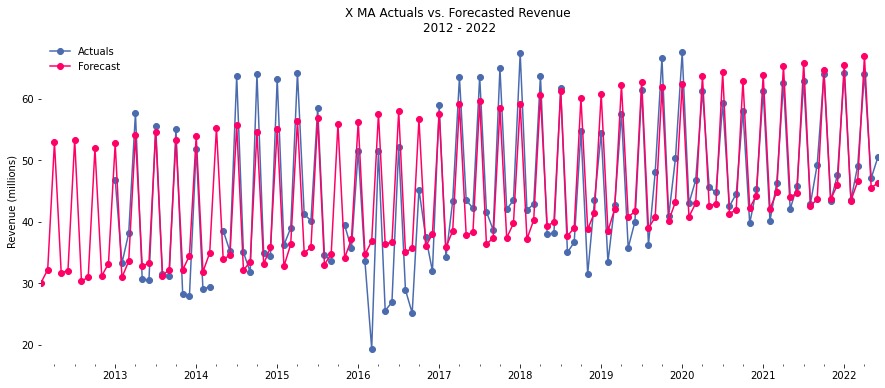

In [137]:
compare(actuals_df,forecast).tail(6)

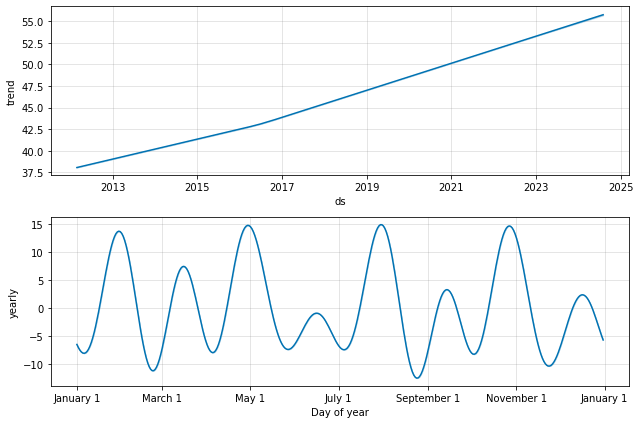

In [138]:
model.plot_components(forecast);

In [139]:
def accuracy(model,months_out):
    
    cv_df = cross_validation(model, horizon  = str(30.4167*months_out) + ' days'
                                  , period   = str(30.4167) + ' days'
                                  , parallel ='processes')
    pm_df = performance_metrics(cv_df)
    
    pm_df['accuracy'] = (1 - pm_df['mape']).round(3)
    pm_df['days out'] = pm_df['horizon']
    pm_df['months out'] = pm_df['months out'] = (((pm_df['horizon'].astype(str).str[:3].str.strip().str.replace(' d','').astype(int))/30).round(3)).astype(str)
    pm_df['months out'] = pm_df['months out'].astype(float).astype(int)
    pm_df['Forecast Model'] = 'X MA'
    pm_df = pm_df[['Forecast Model', 'days out', 'months out', 'mse', 'rmse', 'mae', 'mape', 'mdape', 'coverage','accuracy']]
    pm_df.columns = ['Forecast Model', 'Days Out', 'Months Out', 'MSE', 'RMSE', 'MAE', 'MAPE', 'MDAPE', 'Coverage', 'Accuracy']
    
    return pm_df.groupby(['Forecast Model','Months Out'], as_index=False).mean()

In [140]:
accuracy_results1 = accuracy(model,months_out)
accuracy_results1.head(10)

INFO:fbprophet:Making 9 forecasts with cutoffs between 2019-08-30 19:58:22.080000 and 2020-04-30 03:58:45.120000
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb97af1b490>


,Forecast Model,Months Out,MSE,RMSE,MAE,MAPE,MDAPE,Coverage,Accuracy
0,X MA,2,42.246416,6.499724,5.571051,0.107235,0.099430,0.565217,0.893000
1,X MA,3,38.910595,6.236127,5.423157,0.105697,0.091744,0.618357,0.894111
2,X MA,4,39.565058,6.286775,5.568421,0.108115,0.097704,0.589372,0.891889
3,X MA,5,41.191664,6.416352,5.709243,0.110245,0.106595,0.560386,0.889778
4,X MA,6,38.424696,6.197543,5.456430,0.105601,0.108462,0.608696,0.894333
5,X MA,7,34.193929,5.845919,5.155627,0.102386,0.105625,0.700483,0.897556
6,X MA,8,29.273140,5.408808,4.823900,0.098204,0.106583,0.758454,0.901778
7,X MA,9,25.469766,5.043522,4.578551,0.095169,0.105487,0.768116,0.904778
8,X MA,10,21.612751,4.647210,4.216064,0.088333,0.098590,0.768116,0.911889
9,X MA,11,19.257232,4.385157,3.890996,0.081416,0.082235,0.811594,0.918444


So, not bad for the first round.  The fit isn't great but we still are able to hover around a 90% accuracy, which is an average of multiple lines with the same months out count.

#### Round 2

In [141]:
model = Prophet()
model.add_regressor('hw')
model.fit(actuals_df)
future_df = actuals_df[['ds','hw']]
forecast = model.predict(future_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,Actuals,Forecast
ds,,
2022-01-31,64.201651,69.375628
2022-02-28,43.490665,43.295997
2022-03-31,49.092953,46.448516
2022-04-30,64.041966,67.154838
2022-05-31,47.060985,46.148655
2022-06-30,50.527594,46.032336


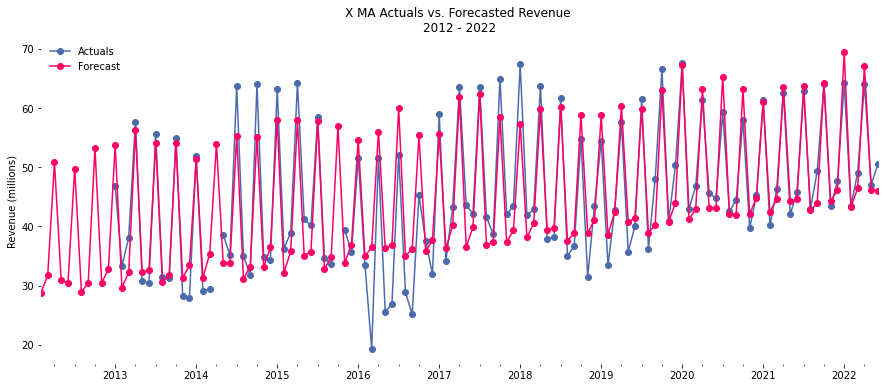

In [142]:
compare(actuals_df,forecast).tail(6)

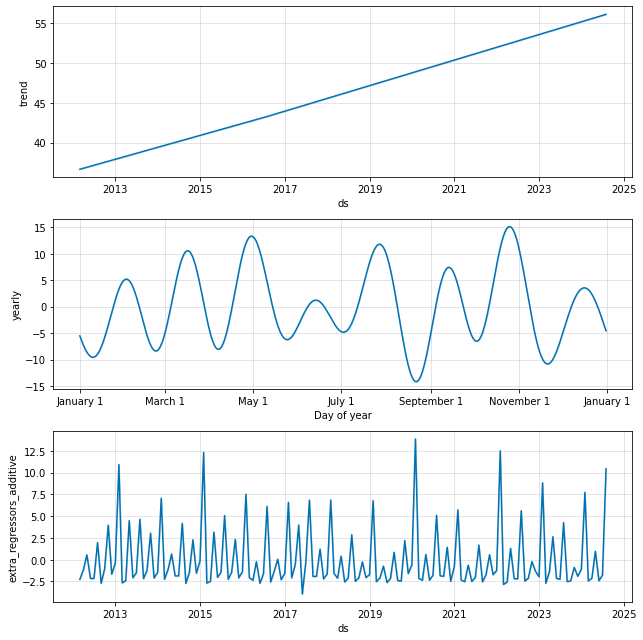

In [143]:
model.plot_components(forecast);

In [144]:
accuracy_results2 = accuracy(model,months_out)
accuracy_results2.head(12)

INFO:fbprophet:Making 9 forecasts with cutoffs between 2019-08-30 19:58:22.080000 and 2020-04-30 03:58:45.120000
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb979799b80>


,Forecast Model,Months Out,MSE,RMSE,MAE,MAPE,MDAPE,Coverage,Accuracy
0,X MA,2,24.976645,4.997664,3.608149,0.073411,0.050754,0.695652,0.927000
1,X MA,3,22.549702,4.745981,3.515032,0.071411,0.050993,0.729469,0.928556
2,X MA,4,22.250695,4.709237,3.670988,0.073728,0.051513,0.705314,0.926333
3,X MA,5,24.899278,4.985076,4.053309,0.080820,0.060924,0.676329,0.919000
4,X MA,6,24.481466,4.945213,4.117072,0.082587,0.067565,0.714976,0.917556
5,X MA,7,25.553070,5.051495,4.381179,0.088857,0.072092,0.758454,0.911222
6,X MA,8,24.842150,4.982068,4.491057,0.091735,0.075779,0.772947,0.908333
7,X MA,9,22.460709,4.736831,4.393473,0.090851,0.076711,0.768116,0.909000
8,X MA,10,19.125393,4.371821,4.076036,0.085377,0.076329,0.768116,0.914667
9,X MA,11,17.535668,4.185281,3.851081,0.081173,0.073344,0.811594,0.918889


Round 2 was a little bit better.  We went from 90% to about roughly 92% due to the regressor, which was able to hit on historically high and low sales months.  However, the numbers are inconsistent.  We would expect to see a slow predictable decline in accuracy over time.  In this case, 90 - 93% creates a range of variance that raises eyebrows.

#### Round 3

In [145]:
model = Prophet(yearly_seasonality=4)
model.add_seasonality(name='2-Year Z Cycle',
                      period= (26/12) * 365.25,
                      fourier_order=4)
model.add_regressor('hw')
model.fit(actuals_df)
future_df = actuals_df[['ds','hw']]
forecast = model.predict(future_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,Actuals,Forecast
ds,,
2022-01-31,64.201651,69.061733
2022-02-28,43.490665,44.328834
2022-03-31,49.092953,47.573267
2022-04-30,64.041966,68.878935
2022-05-31,47.060985,48.190098
2022-06-30,50.527594,48.203505


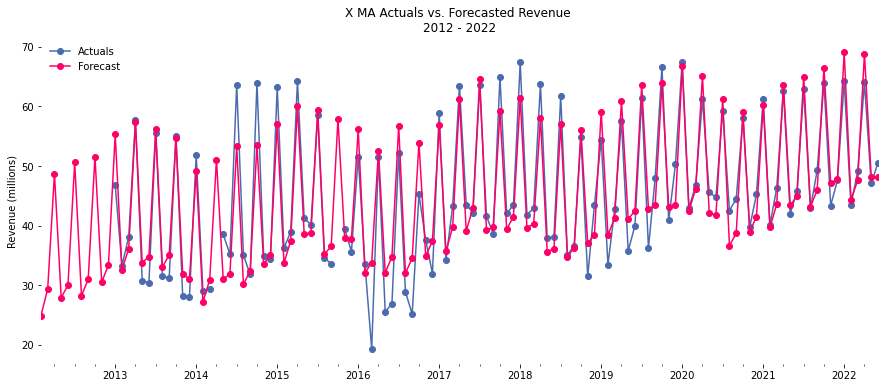

In [146]:
compare(actuals_df,forecast).tail(6)

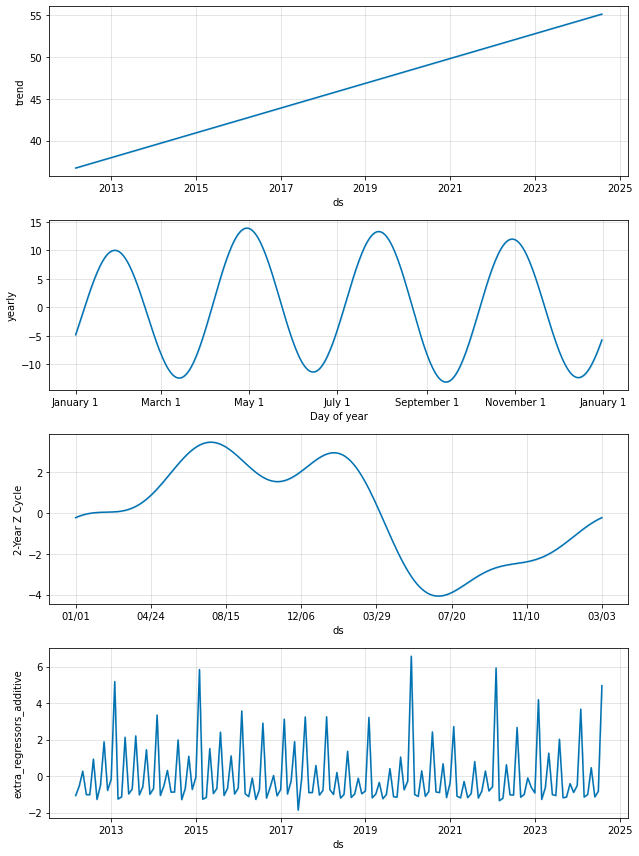

In [147]:
model.plot_components(forecast);

In [148]:
accuracy_results3 = accuracy(model,months_out)
accuracy_results3.head(12)

INFO:fbprophet:Making 9 forecasts with cutoffs between 2019-08-30 19:58:22.080000 and 2020-04-30 03:58:45.120000
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb97afef310>


,Forecast Model,Months Out,MSE,RMSE,MAE,MAPE,MDAPE,Coverage,Accuracy
0,X MA,2,20.332309,4.509136,3.428689,0.069296,0.057359,0.695652,0.931000
1,X MA,3,18.978871,4.355413,3.335048,0.065589,0.054636,0.739130,0.934444
2,X MA,4,18.773089,4.330341,3.298355,0.065322,0.057411,0.763285,0.934778
3,X MA,5,20.907510,4.570675,3.422757,0.069447,0.073702,0.724638,0.930444
4,X MA,6,23.799110,4.875952,3.677856,0.076633,0.078908,0.647343,0.923444
5,X MA,7,25.561520,5.054310,3.911209,0.083018,0.078908,0.613527,0.917000
6,X MA,8,26.994228,5.194889,4.125254,0.088025,0.080822,0.608696,0.912111
7,X MA,9,26.809087,5.176733,4.140967,0.090051,0.081732,0.685990,0.909778
8,X MA,10,25.336751,5.033123,3.902508,0.086290,0.076920,0.734300,0.913778
9,X MA,11,22.551173,4.746241,3.496002,0.077988,0.038939,0.772947,0.922000


Round 3 by far yielded the best results so far.  By incorporating custom seasonality, the hw regressor, and a few tuning parameteres like Fourier Order, we were able to achieve a consistent 93%.  Now that we have a winning model, we can forecast into the future.

## 5. Forecast

Once we are confident in our test, train, split results, the model is now fit to the entire dataset and a forecast in created that now goes beyond the test set by the number of months out we specified at the beginning of the notebook.  Notice how the .fit function now contains our original df instead of the training set.

In [149]:
model = Prophet(yearly_seasonality=4)
model.add_seasonality(name='2-Year Z Cycle',
                      period= (26/12) * 365.25,
                      fourier_order=4)
model.add_regressor('hw')
model.fit(actuals_df)
future_df = actuals_df[['ds','hw']]
#future_df = model.make_future_dataframe(periods=0,freq='M')
forecast = model.predict(future_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [150]:
actuals_df3 = actuals_df.copy()
actuals_df3 = actuals_df3[['ds','y']][:-35 + months_out].set_index('ds',drop=True)
forecast3 = forecast.copy()
forecast3 = forecast3[['ds','yhat']][:-35 + months_out].set_index('ds',drop=True)
compare3  = pd.concat([actuals_df3, forecast3], axis=1).reset_index(drop=False)
compare3 =  compare3[['ds','y','yhat']]
compare3.columns = ['Date','Actuals','Forecast'] 
compare3['Year'] = compare3['Date'].dt.year.astype(str)
compare3['Quarter'] = compare3['Date'].dt.quarter.astype(str)
compare3['Period'] = compare3['Quarter'] + 'Q' + compare3['Year'].str[-2:]
compare3 = compare3.groupby(['Year','Quarter','Period'],as_index=False).sum()
compare3 = compare3[['Period','Actuals','Forecast']]

In [151]:
forecast['product_cycle'] = forecast['2-Year Z Cycle'] + forecast['trend']

,Period,Actuals,Forecast
36,1Q21,147.647387,143.463640
37,2Q21,150.277158,151.946304
38,3Q21,155.071503,154.100974
39,4Q21,154.956080,161.326697
40,1Q22,156.785269,160.963834
41,2Q22,161.630545,165.272539
42,3Q22,0.000000,151.382577
43,4Q22,0.000000,144.956739
44,1Q23,0.000000,151.656409
45,2Q23,0.000000,159.742128


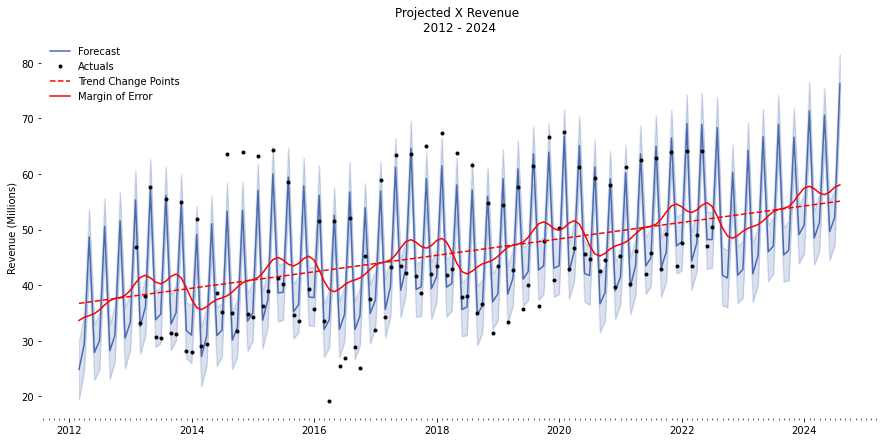

In [152]:
x = np.array(forecast['ds'])
x2 = np.array(actuals_df['ds'])
actuals = actuals_df['y']
y_lower = np.array(forecast['yhat_lower'])
y_upper = np.array(forecast['yhat_upper'])
y_hat = forecast['yhat']
trend = forecast['trend']
product_cycle = forecast['2-Year Z Cycle'] + forecast['trend']

fig, ax1 = plt.subplots(figsize=(15,7))

year_begin = forecast.set_index('ds').index.year[0].astype(str)
year_end = forecast.set_index('ds').index.year[-1].astype(str)
    
title='Projected X Revenue \n' + year_begin + ' - ' + year_end

ax1.set_title(title)
ax1.set(ylabel='Revenue (Millions)')
ax1.plot(x, y_lower, color='#4B6BAF' ,alpha=0.1,label='_nolegend_')
ax1.plot(x, y_upper, color='#4B6BAF', alpha=0.1, label='_nolegend_')
ax1.plot(x, y_hat, color='#4B6BAF', alpha=None)
ax1.plot(x2, actuals, '.',color='black')
ax1.plot(x, trend, '--',color='red')
ax1.plot(x2, product_cycle, '-',color='red')
ax1.fill_between(x, y_lower, y_upper, where=(y_lower < y_upper), color='#4B6BAF', alpha=0.2)
 
ax1.legend(['Forecast','Actuals','Trend Change Points','Margin of Error'],frameon=False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.autoscale(axis='ds',tight=True)

months = mdates.MonthLocator()
ax1.xaxis.set_minor_locator(months);

compare3.tail(12)

## 6. Format & Export Results to CSV

#### Format Forecast & Accuracy DataFrames

Here we format the forecast dataframe to have year, quarter, month, geo, and platform column so we can reference them in the TSS WW excel revenue model via a SUMIFS function. Finally, the forecast_df.to_csv function exports that table to our Box folder destination as a csv file.

In [153]:
forecast_df = forecast[['ds','trend','product_cycle','yhat_lower','yhat_upper','yhat']]

In [154]:
pd.options.mode.chained_assignment = None
forecast_df['Year'] = forecast_df['ds'].dt.year
forecast_df['Month'] = forecast_df['ds'].dt.month
forecast_df['Quarter'] = forecast_df['ds'].dt.quarter
forecast_df['Product'] = 'X'
forecast_df['Geo'] = 'WW'

In [155]:
forecast_df['Quarter'] = forecast_df['Quarter'].astype(str)
forecast_df['Quarter'] = "Q" + forecast_df['Quarter']

In [156]:
forecast_df = forecast_df[['ds','Year','Quarter','Month','Geo','Product','trend','product_cycle','yhat_lower','yhat_upper','yhat']]
forecast_df.columns = ['Date','Year','Quarter','Month','Geo','Product','Trend','Product Cycle','Lower Margin','Upper Margin','Revenue']

In [157]:
accuracy_df = accuracy_results3[['Forecast Model', 'Months Out', 'MSE', 'RMSE', 'MAE', 'MAPE','MDAPE', 'Coverage', 'Accuracy']]

#### Export Test Data (Accuracy) to CSV

In [158]:
forecast_df.to_csv('x_forecast.csv', index=False)

In [159]:
accuracy_df.to_csv('x_accuracy.csv', index=False)